In [48]:
import os
import json
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

In [49]:
# Verificar se a GPU está disponível
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

GPU is not available


In [50]:
# Diretório onde estão armazenadas as imagens sem ser separadas por pastas
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [51]:
def load_image(image_path, target_size=(112, 112)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)
        return np.array(image) / 255.0  # Normaliza a imagem para a faixa [0, 1]
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [52]:
# Caminho para o arquivo de IDs das imagens com fundo dark
ids_dark = r'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\dark_images_ids.txt'

# Carregar IDs do grupo de treinamento de um arquivo de texto
with open(ids_dark, 'r') as file:
    ids = [line.strip() for line in file.readlines()]

In [53]:
print(f"Número de IDs carregados: {len(ids)}")
print(f"Primeiros 5 IDs: {ids[:5]}")

Número de IDs carregados: 9649
Primeiros 5 IDs: ['10000', '10001', '10002', '10003', '10004']


In [54]:
# Dividir os IDs em treinamento e validação (por exemplo, 80% para treinamento e 20% para validação)
split_index = int(len(ids) * 0.8)
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [55]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue

        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue

        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue

        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [56]:
print(f"Número de imagens no conjunto de treinamento: {len(train_data)}")
print(f"Número de imagens no conjunto de validação: {len(val_data)}")

Número de imagens no conjunto de treinamento: 7718
Número de imagens no conjunto de validação: 1930


In [57]:
# Separar caminhos de imagem e rótulos para treinamento e validação
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

In [58]:
# Converter os rótulos em formato adequado (numérico), se necessário
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [59]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Transformar os rótulos em one-hot encoding
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))


In [60]:
# Criar gerador de dados personalizado
class DataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size=32, target_size=(112, 112)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [load_image(self.image_paths[i], self.target_size) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indices)

In [61]:
# Criar os geradores de treinamento e validação
train_generator = DataGenerator(train_images, train_labels_one_hot, batch_size=32)
val_generator = DataGenerator(val_images, val_labels_one_hot, batch_size=32)

In [62]:
# Carregar o modelo base ResNet50 com pesos pré-treinados da ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(112, 112, 3))

In [63]:
# Congelar as camadas da ResNet50 para treinar apenas as camadas personalizadas
base_model.trainable = False

In [64]:
# Adicionar novas camadas no topo do modelo base
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

In [65]:
# Criar o modelo final
model = Model(inputs=base_model.input, outputs=predictions)

In [76]:
# Fine-tuning 
# Descongelar as últimas camadas da ResNet50 para fazer fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [77]:
# Recompilar o modelo 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [78]:
# Treinar o modelo com fine-tuning
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
242/242 [==============================] - 2410s 10s/step - loss: 1.4234 - accuracy: 0.3951 - val_loss: 1.5614 - val_accuracy: 0.3870
Epoch 2/10
242/242 [==============================] - 2825s 12s/step - loss: 1.3116 - accuracy: 0.4399 - val_loss: 1.3034 - val_accuracy: 0.4373
Epoch 3/10
242/242 [==============================] - 3629s 15s/step - loss: 1.2769 - accuracy: 0.4671 - val_loss: 1.2379 - val_accuracy: 0.4705
Epoch 4/10
242/242 [==============================] - 1990s 8s/step - loss: 1.2420 - accuracy: 0.4765 - val_loss: 1.6177 - val_accuracy: 0.3876
Epoch 5/10
242/242 [==============================] - 1982s 8s/step - loss: 1.2076 - accuracy: 0.4970 - val_loss: 1.6120 - val_accuracy: 0.3834
Epoch 6/10
242/242 [==============================] - 1973s 8s/step - loss: 1.1911 - accuracy: 0.5088 - val_loss: 1.4078 - val_accuracy: 0.3653
Epoch 7/10
242/242 [==============================] - 1981s 8s/step - loss: 1.1672 - accuracy: 0.5222 - val_loss: 1.5764 - val_accura

In [79]:
model.save('trained_model.resnet_dark')

INFO:tensorflow:Assets written to: trained_model.resnet_dark\assets


INFO:tensorflow:Assets written to: trained_model.resnet_dark\assets


In [80]:
# Evaluate the model using the validation data generator
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Loss on validation set: {val_loss}")
print(f"Accuracy on validation set: {val_accuracy}")

61/61 [==============================] - 404s 7s/step - loss: 1.1447 - accuracy: 0.5192
Loss on validation set: 1.144667148590088
Accuracy on validation set: 0.5191709995269775


In [81]:
from sklearn.metrics import confusion_matrix, classification_report

# Carregar e processar as imagens de validação
val_images_processed = np.array([load_image(img_path) for img_path in val_images])

# Verificar se há alguma imagem que não foi carregada corretamente
val_images_processed = np.array([img for img in val_images_processed if img is not None])

# Obter previsões do modelo
val_predictions = model.predict(val_images_processed)

# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
target_names = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=target_names)
print("Relatório de Classificação:")
print(class_report)

61/61 [==============================] - 43s 668ms/step
Matriz de Confusão:
[[197  13  46 208   4]
 [ 61  86  15 152   5]
 [ 21   8 241  85   5]
 [  6   5  67 287   0]
 [ 16  22  86 103 191]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.65      0.42      0.51       468
    Classe 1       0.64      0.27      0.38       319
    Classe 2       0.53      0.67      0.59       360
    Classe 3       0.34      0.79      0.48       365
    Classe 4       0.93      0.46      0.61       418

    accuracy                           0.52      1930
   macro avg       0.62      0.52      0.51      1930
weighted avg       0.63      0.52      0.52      1930



In [82]:
# Salvar a matriz de confusão e o relatório de classificação
np.save('confusion_matrix.npy', conf_matrix)

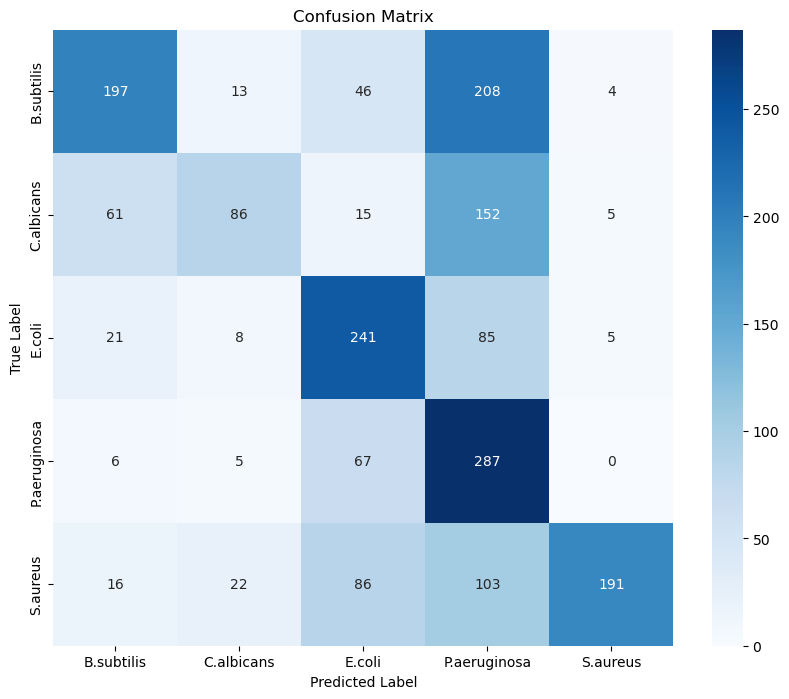

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

__Acurácia na validação:__ 0.519 (ou 51.92%)
A acurácia é moderada e indica que o modelo está ligeiramente acima do nível de aleatoriedade (que seria 20% para um problema de 5 classes). No entanto, ainda há espaço para melhorias significativas.


__Loss na validação:__ 1.1447
O valor de loss sugere que o modelo está enfrentando dificuldades em se ajustar completamente aos dados, o que pode indicar a necessidade de mais ajustes.

__Classe 0:__ Tem uma boa precisão (0.65), mas o recall é baixo (0.42), indicando que o modelo é mais conservador na classificação como Classe 0.

__Classe 1:__ Baixa recall (0.27), indicando que o modelo tem dificuldades em identificar corretamente essa classe.

__Classe 2:__ O F1-score de 0.59 sugere um desempenho moderado, com o modelo equilibrando bem precisão e recall.

__Classe 3:__ O recall é alto (0.79), mas a precisão é baixa (0.34), indicando que o modelo classifica muitas amostras como Classe 3, mesmo quando não deveria.

__Classe 4:__ Alta precisão (0.93), mas baixa recall (0.46), sugerindo que, quando o modelo classifica algo como Classe 4, geralmente está certo, mas perde muitas instâncias dessa classe.